In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


### Params

In [5]:
batch_size = 32
img_height = 180
img_width = 180

data_dir = '/home/siva/Desktop/dataset/'

### Training and Test Datasets

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 994 files belonging to 2 classes.
Using 796 files for training.


2023-09-04 21:30:55.914403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-04 21:30:56.199072: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 994 files belonging to 2 classes.
Using 198 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)


['mammooty', 'mohanlal']


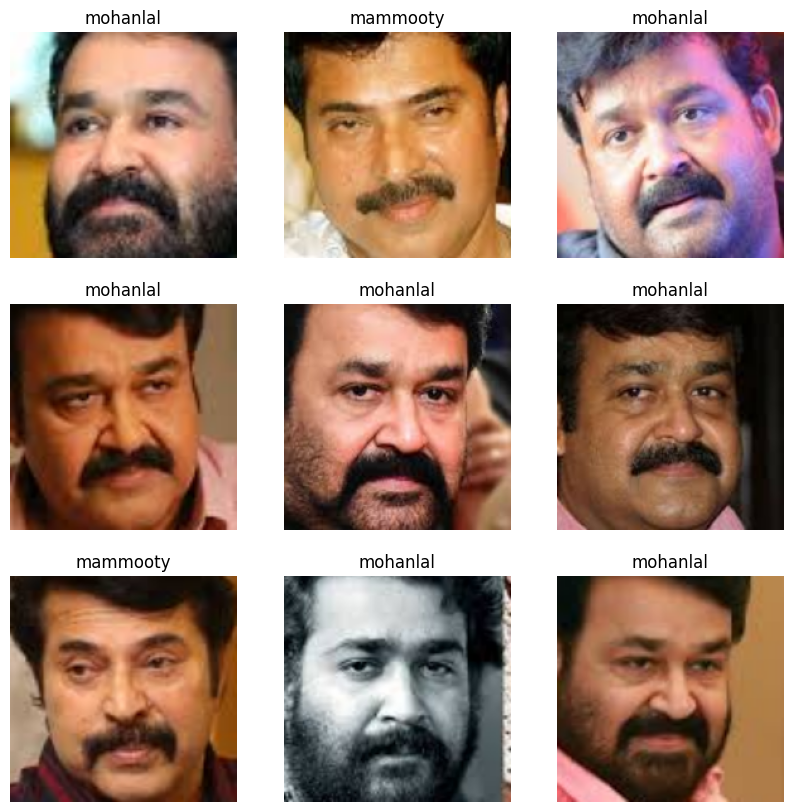

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


### Tuning for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [11]:
normalization_layer = layers.Rescaling(1./255)


In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


### The Model

In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [15]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Training

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
25/25 [==============================] - 12s 430ms/step - loss: 0.6496 - accuracy: 0.6709 - val_loss: 0.5961 - val_accuracy: 0.7020
Epoch 2/10
25/25 [==============================] - 11s 425ms/step - loss: 0.4514 - accuracy: 0.7889 - val_loss: 0.3525 - val_accuracy: 0.8131
Epoch 3/10
25/25 [==============================] - 11s 422ms/step - loss: 0.2350 - accuracy: 0.9095 - val_loss: 0.1375 - val_accuracy: 0.9394
Epoch 4/10
25/25 [==============================] - 10s 420ms/step - loss: 0.0797 - accuracy: 0.9761 - val_loss: 0.1091 - val_accuracy: 0.9495
Epoch 5/10
25/25 [==============================] - 11s 439ms/step - loss: 0.0349 - accuracy: 0.9937 - val_loss: 0.0501 - val_accuracy: 0.9848
Epoch 6/10
25/25 [==============================] - 10s 412ms/step - loss: 0.0256 - accuracy: 0.9887 - val_loss: 0.0684 - val_accuracy: 0.9798
Epoch 7/10
25/25 [==============================] - 11s 422ms/step - loss: 0.0170 - accuracy: 0.9975 - val_loss: 0.0483 - val_accuracy: 0.9798

In [23]:
model.save("conv2d-mmc.h5")

### Training results

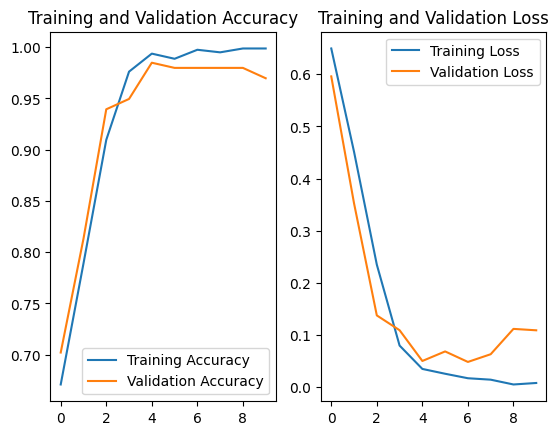

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# plt.figure(figsize=(8, 18))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Testing

In [19]:
def test(path):
    img = tf.keras.utils.load_img(
        path, target_size=(img_height, img_width)
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array,verbose=False)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

import os
for image in os.listdir("test_images/"):
    print("Testing with image ",image)
    test("test_images/"+image)
    print("\n")

Testing with image  mohanlal.png
This image most likely belongs to mohanlal with a 100.00 percent confidence.


Testing with image  mamooty01.png
This image most likely belongs to mohanlal with a 100.00 percent confidence.


Testing with image  mohanlal346.png
This image most likely belongs to mohanlal with a 100.00 percent confidence.


Testing with image  mamooty06.png
This image most likely belongs to mohanlal with a 99.98 percent confidence.


Testing with image  mohanlal341.png
This image most likely belongs to mohanlal with a 100.00 percent confidence.


Testing with image  mohanlal347.png
This image most likely belongs to mohanlal with a 100.00 percent confidence.


Testing with image  mamooty03.png
This image most likely belongs to mohanlal with a 97.49 percent confidence.


Testing with image  mamooty.png
This image most likely belongs to mohanlal with a 100.00 percent confidence.


Testing with image  mohanlal339.png
This image most likely belongs to mohanlal with a 100.00 pe